## BUSINESS PROBLEM	


##### If Microsoft or any organization were to consider breaking through into the film industry, it is important to consider that movie production is a high – risk / high reward type of investment. Typically it requires substantial capital and there are varying but overall low chances of success. Leveraging current data from several sources (including databases like IMDB, Rotten Tomatoes, The Numbers)  we have developed a strategy to breakthrough to this new industry that equates to profitable returns all the while minimizing investment risk. The questions we aim to answer are:

Who are the top production studios in the industry and what genres are they capitalizing on?
As a new studio, should we choose to compete in those genres or are there profitable alternatives?
How much of an investment is needed to reach sustainable profit (long term)?
Are there additional trends successful franchises share that we can capitalize on?
After understanding the type of film to be profitable and the level of investment needed, how do we determine the talent that will ensure success of this project?


## Calculations and Analyses:

### Import all neccessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sqlite3

plt.style.use('seaborn')
sns.set_palette("colorblind")

conn = sqlite3.connect('zippedData/im.db')

%matplotlib inline

### Read in TN Movie Budgets Dataset

Clean data, chose relevant columns for financial analyses 

In [2]:
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
money_columns = ['production_budget','domestic_gross','worldwide_gross']
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].map(lambda x: x[-4:]).astype(float)
tn_movie_budgets[money_columns] = tn_movie_budgets[money_columns].replace([',','\$'], '', regex = True).astype(float)
tn_movie_budgets['profit'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets['ROI'] = tn_movie_budgets['profit'] / tn_movie_budgets['production_budget']
tn_movie_budgets['profit_margin'] = tn_movie_budgets['profit'] / tn_movie_budgets['worldwide_gross'] * 100
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].str.lower()
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].replace([':','\.','\,',"'",'!'], '', regex = True)
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])


tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
0,1,2009-12-18,avatar,425000000.0,760507625.0,2.776345e+09,2009.0,2.351345e+09,5.532577,84.692106
1,2,2011-05-20,pirates of the caribbean on stranger tides,410600000.0,241063875.0,1.045664e+09,2011.0,6.350639e+08,1.546673,60.733080
2,3,2019-06-07,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019.0,-2.002376e+08,-0.572108,-133.703598
3,4,2015-05-01,avengers age of ultron,330600000.0,459005868.0,1.403014e+09,2015.0,1.072414e+09,3.243841,76.436443
4,5,2017-12-15,star wars ep viii the last jedi,317000000.0,620181382.0,1.316722e+09,2017.0,9.997217e+08,3.153696,75.925058
...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,red 11,7000.0,0.0,0.000000e+00,2018.0,-7.000000e+03,-1.000000,-inf
5778,79,1999-04-02,following,6000.0,48482.0,2.404950e+05,1999.0,2.344950e+05,39.082500,97.505146
5779,80,2005-07-13,return to the land of wonders,5000.0,1338.0,1.338000e+03,2005.0,-3.662000e+03,-0.732400,-273.692078
5780,81,2015-09-29,a plague so pleasant,1400.0,0.0,0.000000e+00,2015.0,-1.400000e+03,-1.000000,-inf


### Read in IMDB Dataset

Join SQL tables, drop duplicates, reformatted titles to lowercase only for seamless merging

In [3]:
test_sql_df = pd.read_sql("""
SELECT mb.movie_id, mb.primary_title, mb.start_year, mb.runtime_minutes, mb.genres, p.primary_name, 
pr.category, mr.averagerating, mr.numvotes

FROM movie_basics AS mb
JOIN principals AS pr
    USING(movie_id)
JOIN persons AS p
    USING(person_id)
JOIN movie_ratings as mr
    USING(movie_id)
WHERE pr.category IN ('director')
GROUP BY movie_id, person_id
;
""",conn).drop_duplicates(subset = ['movie_id'])

In [4]:
test_sql_df = test_sql_df.drop_duplicates(subset = ['primary_title','start_year'])
test_sql_df['primary_title'] = test_sql_df['primary_title'].str.lower()
test_sql_df['primary_title'] = test_sql_df['primary_title'].replace([':','\.','\,',"'",'!'], '', regex = True)
test_sql_df

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes
0,tt0063540,sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,director,7.0,77
1,tt0066787,one day before the rainy season,2019,114.0,"Biography,Drama",Mani Kaul,director,7.2,43
2,tt0069049,the other side of the wind,2018,122.0,Drama,Orson Welles,director,6.9,4517
3,tt0069204,sabse bada sukh,2018,NaN,"Comedy,Drama",Hrishikesh Mukherjee,director,6.1,13
4,tt0100275,the wandering soap opera,2017,80.0,"Comedy,Drama,Fantasy",Raoul Ruiz,director,6.5,119
...,...,...,...,...,...,...,...,...,...
77447,tt9913056,swarm season,2019,86.0,Documentary,Sarah Christman,director,6.2,5
77448,tt9913084,diabolik sono io,2019,75.0,Documentary,Giancarlo Soldi,director,6.2,6
77449,tt9914642,albatross,2017,NaN,Documentary,Chris Jordan,director,8.5,8
77450,tt9914942,la vida sense la sara amat,2019,NaN,None,Laura Jou,director,6.6,5


### Merge the IMDB and TN Datasets

By merging tables using BOTH primary title (movie title) and start year (release year), we avoid duplicates- movies that share the same movie title, but were released in different years. 
We also removed any movies that were not profitable. 

In [5]:
sql_budgets_merged = test_sql_df.merge(tn_movie_budgets, left_on = ['primary_title','start_year'], right_on = ['movie','year'])
sql_budgets_merged_profit = sql_budgets_merged[sql_budgets_merged['profit'] > 0]
sql_budgets_merged

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
0,tt0249516,foodfight,2012,91.0,"Action,Animation,Comedy",Lawrence Kasanoff,director,1.9,8248,26,2012-12-31,foodfight,45000000.0,0.0,7.370600e+04,2012.0,-4.492629e+07,-0.998362,-6.095337e+04
1,tt0365907,a walk among the tombstones,2014,114.0,"Action,Crime,Drama",Scott Frank,director,6.5,105116,67,2014-09-19,a walk among the tombstones,28000000.0,26017685.0,6.210859e+07,2014.0,3.410859e+07,1.218164,5.491767e+01
2,tt0369610,jurassic world,2015,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow,director,7.0,539338,34,2015-06-12,jurassic world,215000000.0,652270625.0,1.648855e+09,2015.0,1.433855e+09,6.669092,8.696065e+01
3,tt0376136,the rum diary,2011,119.0,"Comedy,Drama",Bruce Robinson,director,6.2,94787,16,2011-10-28,the rum diary,45000000.0,13109815.0,2.154473e+07,2011.0,-2.345527e+07,-0.521228,-1.088678e+02
4,tt0383010,the three stooges,2012,92.0,"Comedy,Family",Bobby Farrelly,director,5.1,28570,4,2012-04-13,the three stooges,30000000.0,44338224.0,5.405225e+07,2012.0,2.405225e+07,0.801742,4.449815e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,tt8043306,teefa in trouble,2018,155.0,"Action,Comedy,Crime",Ahsan Rahim,director,7.4,2724,8,2018-07-20,teefa in trouble,1500000.0,0.0,9.880600e+04,2018.0,-1.401194e+06,-0.934129,-1.418126e+03
1467,tt8155288,happy death day 2u,2019,100.0,"Drama,Horror,Mystery",Christopher Landon,director,6.3,27462,78,2019-02-13,happy death day 2u,9000000.0,28051045.0,6.417950e+07,2019.0,5.517950e+07,6.131055,8.597683e+01
1468,tt8266310,blinded by the light,2019,117.0,"Biography,Comedy,Drama",Gurinder Chadha,director,6.2,173,64,2019-08-14,blinded by the light,15000000.0,0.0,0.000000e+00,2019.0,-1.500000e+07,-1.000000,-inf
1469,tt8632862,fahrenheit 11/9,2018,128.0,Documentary,Michael Moore,director,6.7,11628,29,2018-09-21,fahrenheit 11/9,5000000.0,6352306.0,6.653715e+06,2018.0,1.653715e+06,0.330743,2.485401e+01


### Read in Genres Breakdown Dataset
Updated data scraped from Rotten Tomatoes 

In [6]:
stats_df = pd.read_csv('zippedData/rt_moviestats.csv')
stats_df

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,More to Life,NaN,Drama,2020,"October 23, 2020 (United States)",3.1,18.0,Joseph Ebanks,Joseph Ebanks,Shannon Bond,United States,7000.0,NaN,NaN,90.0
7664,Dream Round,NaN,Comedy,2020,"February 7, 2020 (United States)",4.7,36.0,Dusty Dukatz,Lisa Huston,Michael Saquella,United States,NaN,NaN,Cactus Blue Entertainment,90.0
7665,Saving Mbango,NaN,Drama,2020,"April 27, 2020 (Cameroon)",5.7,29.0,Nkanya Nkwai,Lynno Lovert,Onyama Laura,United States,58750.0,NaN,Embi Productions,NaN
7666,It's Just Us,NaN,Drama,2020,"October 1, 2020 (United States)",NaN,NaN,James Randall,James Randall,Christina Roz,United States,15000.0,NaN,NaN,120.0


### Explore Market Saturation by Genre

Through this visualization, we see that the film genres that are most populated (highest saturation) are Comedy, Action, and Drama. Sci-Fi and Thriller least populated. 

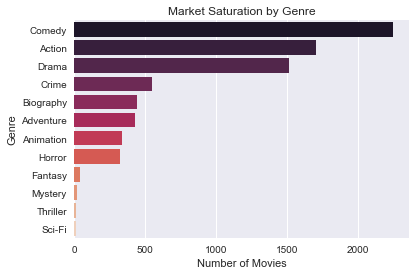

In [7]:
fig, ax = plt.subplots()
ax = sns.countplot( y = 'genre' ,data = stats_df, order = stats_df['genre'].value_counts().index[:12], palette = 'rocket')
ax.set_ylabel('Genre')
ax.set_xlabel('Number of Movies')
ax.set_title('Market Saturation by Genre');

### Create Studios DataFrame 

Cleaned Data and normalized percentages and limited selection to top 7 movie studios

In [8]:
studios_df = pd.read_csv('zippedData/movie_studio_breakdown.csv', skiprows = 1)
studios_df = studios_df.drop([0,1,2])
studios_df['Share'] = list(map(lambda x: x[:-1], studios_df['Share'].values))
studios_df['Share'] = [float(x) for x in studios_df['Share'].values]
studios_df = studios_df.head(7)
studios_df = studios_df.reset_index().drop('index', axis = 1)
studios_df

,Movie Studio,Movies,TotalBoxOffice,Tickets,Share
0,Walt Disney,595,41497060144.00,"5,862,907,921",16.99
1,Warner Bros.,835,37019614688.00,"5,282,558,303",15.16
2,Sony Pictures,766,30475200872.00,"4,442,180,354",12.48
3,Universal,550,29383440355.00,"4,146,808,535",12.03
4,20th Century Fox,525,25857943964.00,"3,792,493,014",10.59
5,Paramount Pictures,504,25532891321.00,"3,774,740,559",10.46
6,Lionsgate,431,9702651888.00,"1,229,003,817",3.97


### Visualize Studio Market Share 

Plotted a piechart of top 7 studio's to visualize overall market share (using Total Box Office Gross)

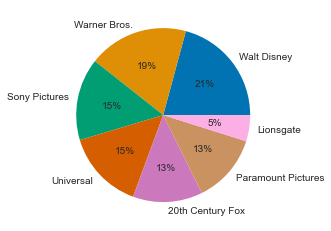

In [9]:
x = studios_df['Share']
y = studios_df['Movie Studio']
plt.pie(x, labels=y, autopct='%.0f%%')
plt.show()

### Visualize Each Studio's Genre Distribution
Using bar charts to further breakdown the movies produced by top 8 studios, we see the genres they have the most films in

In [10]:
Universal_df = stats_df[stats_df['company'] == 'Universal Pictures']
WB_df = stats_df[stats_df['company'] == 'Warner Bros.']
Sony_df = stats_df[stats_df['company'] == 'Columbia Pictures']
Paramount_df = stats_df[stats_df['company'] == 'Paramount Pictures']
twentieth_df = stats_df[stats_df['company'] == 'Twentieth Century Fox']
disney_df = stats_df[stats_df['company'] == 'Walt Disney Pictures']
lionsgate_df = stats_df[stats_df['company'] == 'Lionsgate']
NL_df = stats_df[stats_df['company'] == ('New Line Cinema')]

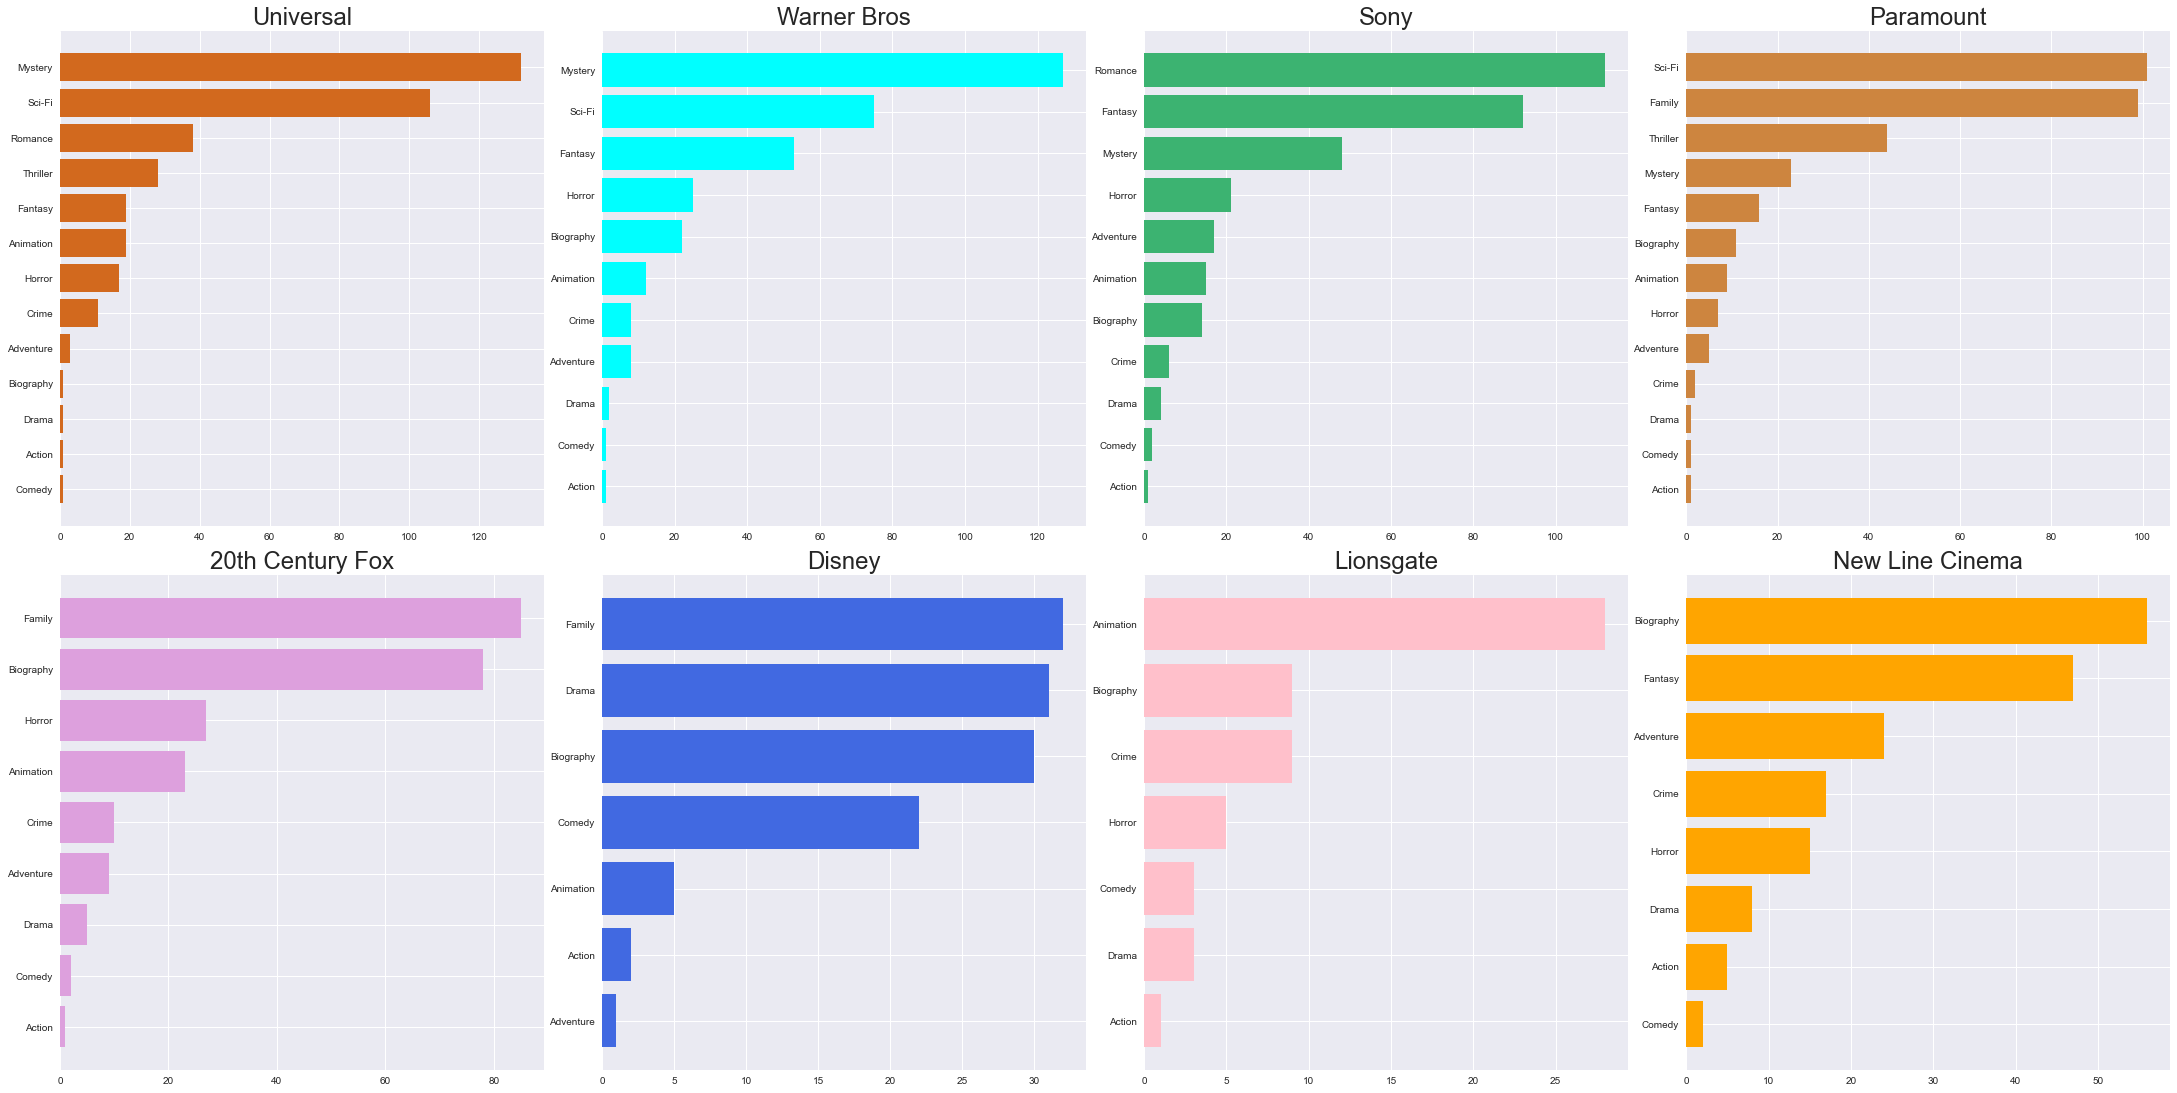

In [11]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4 ,  figsize = (30,15))
fig.tight_layout(w_pad=3, h_pad = 3)
sns.set_context("poster")


ax1.barh(Universal_df['genre'].value_counts().index, sorted(Universal_df['genre'].value_counts().values), color = 'chocolate')
ax1.set_title('Universal')
ax2.barh(WB_df['genre'].value_counts().index, sorted(WB_df['genre'].value_counts().values), color = 'cyan')
ax2.set_title('Warner Bros')
ax3.barh(Sony_df['genre'].value_counts().index, sorted(Sony_df['genre'].value_counts().values), color = 'mediumseagreen')
ax3.set_title('Sony')
ax4.barh(Paramount_df['genre'].value_counts().index, sorted(Paramount_df['genre'].value_counts().values), color = 'peru')
ax4.set_title('Paramount')
ax5.barh(twentieth_df['genre'].value_counts().index, sorted(twentieth_df['genre'].value_counts().values), color = 'plum')
ax5.set_title('20th Century Fox')
ax6.barh(disney_df['genre'].value_counts().index, sorted(disney_df['genre'].value_counts().values), color = 'royalblue')
ax6.set_title('Disney')
ax7.barh(lionsgate_df['genre'].value_counts().index, sorted(lionsgate_df['genre'].value_counts().values), color = 'pink')
ax7.set_title('Lionsgate')
ax8.barh(NL_df['genre'].value_counts().index, sorted(NL_df['genre'].value_counts().values), color = 'orange')
ax8.set_title('New Line Cinema');


### Determine Which Genres Have the Highest Profit Margin

Created a dataframe focusing on each genres financial performance metrics

In [12]:
genres_list = ['Romance','Thriller','Action','Comedy','Drama','Sci-Fi','Documentary','Animation','Fantasy','Adventure','Family','Sport','War']
genres_dict = {}
genres_dict['Genre'] = []
genres_dict['Median Profit Margin'] = []
genres_dict['Median Budget'] = []
genres_dict['Median ROI'] = []
genres_dict['Number of Films'] = []

for genre in genres_list:
    sql_budgets_merged_profit[genre] = sql_budgets_merged_profit['genres'].str.contains(genre)
    #display(sql_budgets_merged.groupby([genre])[['profit_margin']].agg('median').sort_values(by = 'profit_margin', ascending = False))
    
    genres_dict['Genre'].append(genre)
    genres_dict['Median Profit Margin'].append(sql_budgets_merged_profit.groupby([genre])[['profit_margin']].agg('median').sort_values(by = 'profit_margin', ascending = False).iloc[0][0])
    genres_dict['Median Budget'].append(sql_budgets_merged_profit.groupby([genre])[['production_budget']].agg('median').sort_values(by = 'production_budget', ascending = False).iloc[0][0])
    genres_dict['Median ROI'].append(sql_budgets_merged_profit.groupby([genre])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False).iloc[0][0])
    genres_dict['Number of Films'].append(sql_budgets_merged_profit['genres'].str.contains(genre).sum() )
    
#print(sql_budgets_merged['profit_margin'].median())

genres_df = pd.DataFrame(genres_dict)
genres_df = genres_df.sort_values(by = 'Median Profit Margin', ascending = False)
display(genres_df)

<ipython-input-12-539cb3a7aebc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sql_budgets_merged_profit[genre] = sql_budgets_merged_profit['genres'].str.contains(genre)


,Genre,Median Profit Margin,Median Budget,Median ROI,Number of Films
5,Sci-Fi,71.966303,120000000.0,2.567136,105
1,Thriller,71.165513,35000000.0,2.468069,171
2,Action,68.810638,78000000.0,2.206221,336
7,Animation,68.131558,95000000.0,2.137901,95
0,Romance,67.785608,35000000.0,2.104204,136
9,Adventure,67.556816,117000000.0,2.082321,303
10,Family,67.499174,54500000.0,2.076845,72
8,Fantasy,67.482876,75000000.0,2.075303,95
3,Comedy,67.191211,32250000.0,2.047964,390
4,Drama,67.090529,50000000.0,2.038639,450


### Visualize the Results

Using the information above, we created a visual of median profit margins by genre. We see here that Sci-Fi and Thrillers have the highest median profit margins. 

Next, we took the profit margins alongside our data of market saturation to create a plot visualizing the most profitable genres juxtaposed against the movie count of each genre to find that Sci-Fi and Thriller movies are the most profitable genres and have little saturation or competition from other studios. 

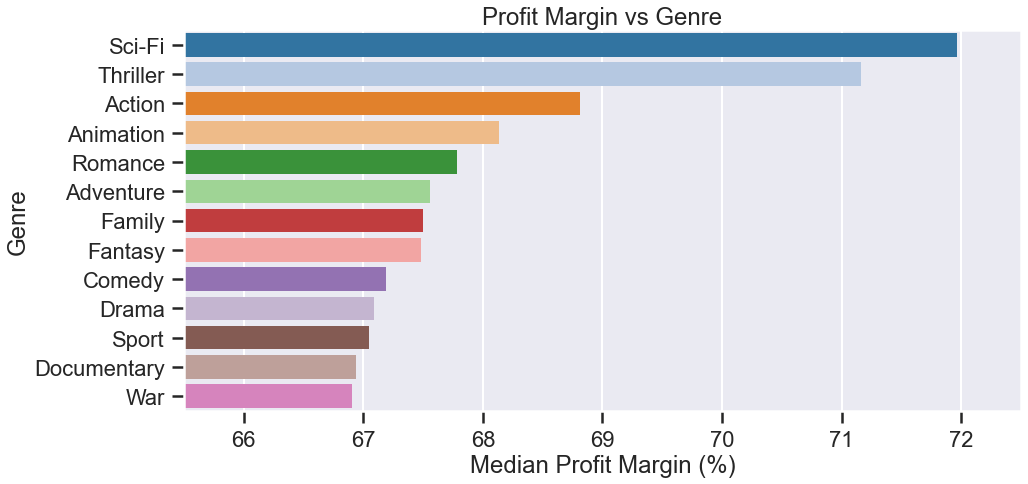

In [13]:
fig,ax = plt.subplots(figsize = (15,7))

ax = sns.barplot(y = 'Genre' , x = 'Median Profit Margin', data = genres_df , palette = 'tab20');
ax.set_xlim(65.5,72.5)
ax.set_xlabel('Median Profit Margin (%)');
ax.set_title('Profit Margin vs Genre');


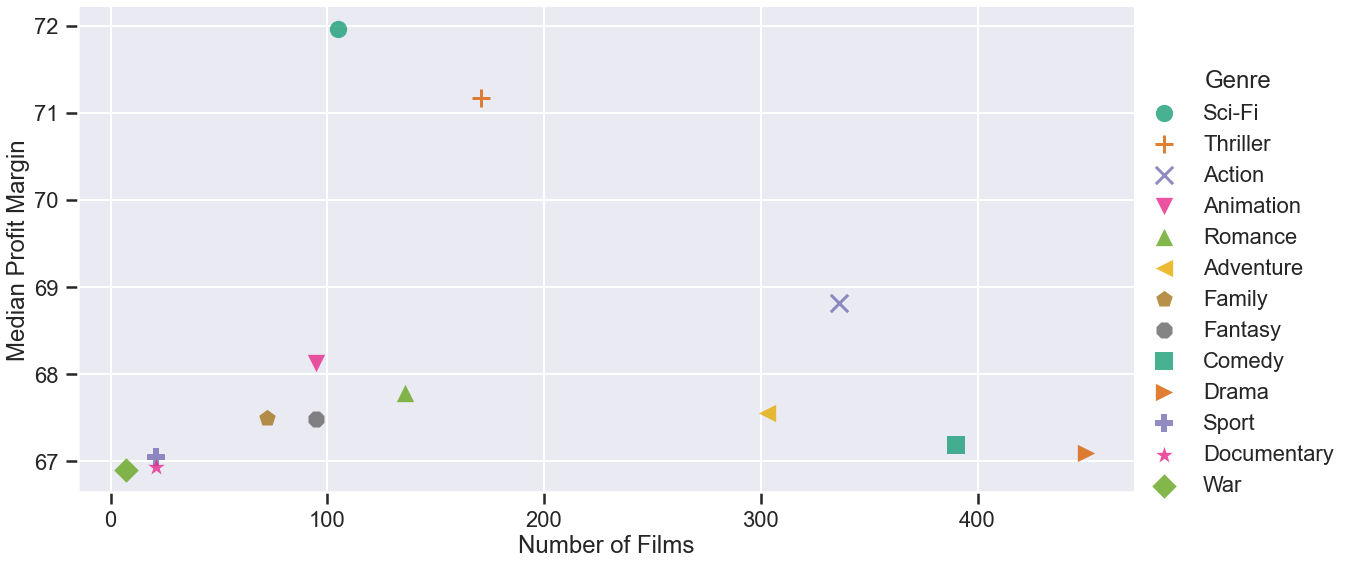

In [14]:
sns.set_context("poster")

sns.lmplot(data = genres_df, x = 'Number of Films', y = 'Median Profit Margin', hue = 'Genre', palette = 'Dark2',
       fit_reg = False, scatter_kws={"s": 300}, height=8, aspect=2, markers=["o","+","x",'v','^','<','p','8','s','>','P','*','D']);

### Data Driven Solution 1: Determine the Ideal Production Budget

Here we created a scatter plot comparing profit margin to production budget. Our visualization produced a trend line where we discovered that, on average- as production budget increases, profit margin decreases. What is the ideal budget needed to achieve a realistic, attainable profit. 

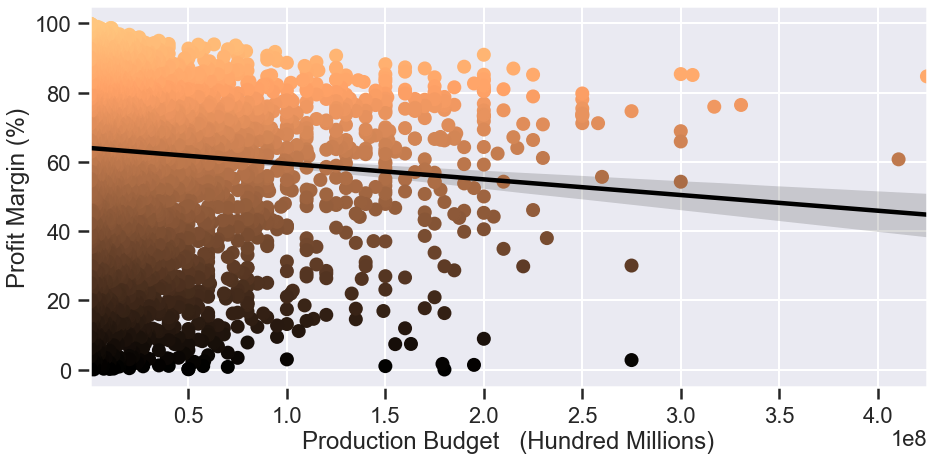

In [15]:
fig, ax = plt.subplots(figsize = (15,7))
profitable_movies = tn_movie_budgets.loc[tn_movie_budgets['profit_margin'] >= 0]


ax = sns.regplot(x ='production_budget', y = 'profit_margin', data = profitable_movies, scatter = False, color = 'black');
ax.scatter(profitable_movies['production_budget'], profitable_movies['profit_margin'], c = profitable_movies["profit_margin"],  cmap="copper");

#ax.hlines(y=60.4, xmin=0, xmax=4e8, linewidth=2, color='cyan')
#ax.vlines(x=0.9e8, ymin=0, ymax=100, linewidth=2, color='cyan')
ax.set_ylabel('Profit Margin (%)');
ax.set_xlabel('Production Budget   (Hundred Millions)');


#current_values = plt.gca().get_xticks()
#plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
#ax.set_xticks(ticks = [50e6,100e6,150e6,200e6,250e6,300e6,350e6,400e6,450e6])

### Negative Correlation (how do we find the 'sweet spot'?)

We loaded additional scraped data from Rotten Tomatoes

In [16]:
rtcurrent = pd.read_csv('zippedData/rotten_tomatoes_movies.csv')
rtcurrent['original_release_date'] = pd.to_datetime(rtcurrent['original_release_date'])
rtcurrent['movie_title'] = rtcurrent['movie_title'].str.lower()
rtcurrent['movie_title'] = rtcurrent['movie_title'].replace([':','\.','\,',"'",'!'], '', regex = True)
rtcurrent

,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,percy jackson & the olympians the lightning thief,"Always trouble-prone, the life of teenager Per...",PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,20th Century Fox,Rotten
1,please give,Kate (Catherine Keener) and her husband Alex (...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,Sony Pictures Classics,Certified-Fresh
2,10,"A successful, middle-aged Hollywood songwriter...",R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,Waner Bros.,Fresh
3,12 angry men (twelve angry men),Following the closing arguments in a murder tr...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,Criterion Collection,Certified-Fresh
4,20000 leagues under the sea,"In 1866, Professor Pierre M. Aronnax (Paul Luk...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,Disney,Fresh
...,...,...,...,...,...,...,...,...,...,...
17707,zoot suit,Mexican-American gangster Henry Reyna (Daniel ...,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981-10-02,MCA Universal Home Video,Rotten
17708,zootopia,From the largest elephant to the smallest shre...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",2016-03-04,Walt Disney Animation Studios,Certified-Fresh
17709,zorba the greek,Traveling to inspect an abandoned mine his fat...,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",1964-12-17,Fox,Fresh
17710,zulu,"In 1879, the Zulu nation hands colonial Britis...",PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964-06-17,Paramount Pictures,Fresh


### Merge with Budget DataFrame

In [17]:
genre_budg = tn_movie_budgets.merge(rtcurrent, left_on = ['movie','release_date'], right_on = ['movie_title','original_release_date'])
genre_budg

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,1,2009-12-18,avatar,425000000.0,760507625.0,2.776345e+09,2009.0,2.351345e+09,5.532577,84.692106,avatar,On the lush alien world of Pandora live the Na...,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",James Cameron,James Cameron,"Zoe Saldana, Sam Worthington, Sigourney Weaver...",2009-12-18,20th Century Fox,Certified-Fresh
1,2,2011-05-20,pirates of the caribbean on stranger tides,410600000.0,241063875.0,1.045664e+09,2011.0,6.350639e+08,1.546673,60.733080,pirates of the caribbean on stranger tides,The checkered past of Capt. Jack Sparrow (John...,PG-13,"Action & Adventure, Comedy, Science Fiction & ...","Dariusz Wolski, Rob Marshall","Rob Marshall, Terry Rossio, Ted Elliott","Johnny Depp, Penelope Cruz, Ian McShane, Geoff...",2011-05-20,Walt Disney Pictures,Rotten
2,3,2019-06-07,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019.0,-2.002376e+08,-0.572108,-133.703598,dark phoenix,The X-Men face their most formidable and power...,PG-13,"Action & Adventure, Drama, Science Fiction & F...",Simon Kinberg,Simon Kinberg,"James McAvoy, Michael Fassbender, Jennifer Law...",2019-06-07,20th Century Fox,Rotten
3,4,2015-05-01,avengers age of ultron,330600000.0,459005868.0,1.403014e+09,2015.0,1.072414e+09,3.243841,76.436443,avengers age of ultron,When Tony Stark (Robert Downey Jr.) jump-start...,PG-13,"Action & Adventure, Science Fiction & Fantasy",Joss Whedon,"Stan Lee, Jack Kirby, Joss Whedon","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",2015-05-01,Walt Disney Pictures,Certified-Fresh
4,7,2018-04-27,avengers infinity war,300000000.0,678815482.0,2.048134e+09,2018.0,1.748134e+09,5.827114,85.352522,avengers infinity war,"Iron Man, Thor, the Hulk and the rest of the A...",PG-13,"Action & Adventure, Science Fiction & Fantasy",Anthony Russo,"Christopher Markus, Stephen McFeely","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",2018-04-27,Walt Disney Pictures,Certified-Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,50,2003-06-13,manito,25000.0,0.0,0.000000e+00,2003.0,-2.500000e+04,-1.000000,-inf,manito,Set and vibrantly photographed in the Washingt...,NR,Drama,Eric Eason,Eric Eason,"Franky G, Leo Minaya, Leo Manaya, Manuel Cabra...",2003-06-13,Film Movement,Fresh
3736,61,2010-04-02,breaking upwards,15000.0,115592.0,1.155920e+05,2010.0,1.005920e+05,6.706133,87.023323,breaking upwards,"A young couple (Daryl Wein, Zoe Lister-Jones) ...",NR,"Drama, Romance",Daryl Wein,"Peter Duchan, Zoe Lister-Jones, Daryl Wein","Daryl Wein, Zoe Lister-Jones, Julie White, Oli...",2010-04-02,IFC Films,Fresh
3737,74,1993-02-26,el mariachi,7000.0,2040920.0,2.041928e+06,1993.0,2.034928e+06,290.704000,99.657187,el mariachi,El Mariachi (Carlos Gallardo) is a traveling g...,R,"Action & Adventure, Art House & International,...",Robert Rodriguez,"Robert Rodriguez, Carlos Gallardo","Carlos Gallardo, Consuelo Gómez, Reinol Martin...",1993-02-26,Sony Pictures Home Entertainment,Fresh
3738,75,2004-10-08,primer,7000.0,424760.0,8.419260e+05,2004.0,8.349260e+05,119.275143,99.168573,primer,Intellectual engineers Aaron (Shane Carruth) a...,PG-13,"Drama, Mystery & Suspense, Science Fiction & F...",Shane Carruth,Shane Carruth,"Shane Carruth, David Sullivan, Casey Gooden, A...",2004-10-08,ThinkFilm,Fresh


### Find the Median Profit Margin of the top studios 

We decided to focus on performance of the top studios; in order to gauge a realistic, attainable return we cleaned and consolidated the data to create a dataframe containing financials (budget, profit, ROI, profit margin, etc.)



In [18]:
genre_budg
genre_budg['production_company'] = genre_budg['production_company'].str.lower()
genre_budg['production_company']  = genre_budg['production_company'].replace([':','\.','\,',"'",'!'], '', regex = True)

genre_budg = genre_budg.dropna(subset = ['production_company'])



genre_budg.loc[genre_budg['production_company'].str.contains('century fox'),['production_company'] ] = '20th Century Fox'
genre_budg.loc[genre_budg['production_company'].str.contains('warner'),['production_company'] ] = 'Warner Bros'
genre_budg.loc[genre_budg['production_company'].str.contains('sony'),['production_company'] ] = 'Sony Sictures'
genre_budg.loc[genre_budg['production_company'].str.contains('paramount'),['production_company'] ] = 'Paramount'
genre_budg.loc[genre_budg['production_company'].str.contains('universal'),['production_company'] ] = 'Universal'
genre_budg.loc[genre_budg['production_company'].str.contains('columbia'),['production_company'] ] = 'Columbia Pictures'
genre_budg.loc[genre_budg['production_company'].str.contains('new line'),['production_company'] ] = 'New Line Cinema'
genre_budg.loc[genre_budg['production_company'].str.contains('walt '),['production_company'] ] = 'Walt Disney'
genre_budg.loc[genre_budg['production_company'].str.contains('miramax'),['production_company'] ] = 'Miramax'
genre_budg.loc[genre_budg['production_company'].str.contains('mgm'),['production_company'] ] = 'MGM'
genre_budg.loc[genre_budg['production_company'].str.contains('lionsgate'),['production_company'] ] = 'Lionsgate'
genre_budg.loc[genre_budg['production_company'].str.contains('focus'),['production_company'] ] = 'Focus Features'



C:\Users\paperspace\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### Create Top 10 Studios Dataframe
Narrowed our results to the top 10 studios 

In [19]:
top_10_studios = list(genre_budg['production_company'].value_counts().head(10).index)
top_10_df = genre_budg.loc[genre_budg['production_company'].isin(top_10_studios)]
top_10_df = top_10_df.loc[genre_budg['profit'] > 10 ]

top_10_df 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin,movie_title,movie_info,content_rating,genres,directors,authors,actors,original_release_date,production_company,tomatometer_status
0,1,2009-12-18,avatar,425000000.0,760507625.0,2.776345e+09,2009.0,2.351345e+09,5.532577,84.692106,avatar,On the lush alien world of Pandora live the Na...,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",James Cameron,James Cameron,"Zoe Saldana, Sam Worthington, Sigourney Weaver...",2009-12-18,20th Century Fox,Certified-Fresh
5,9,2017-11-17,justice league,300000000.0,229024295.0,6.559452e+08,2017.0,3.559452e+08,1.186484,54.264473,justice league,Fueled by his restored faith in humanity and i...,PG-13,"Action & Adventure, Drama, Science Fiction & F...",Zack Snyder,"Chris Terrio, Joss Whedon","Ben Affleck, Henry Cavill, Amy Adams, Gal Gado...",2017-11-17,Warner Bros,Rotten
6,10,2015-11-06,spectre,300000000.0,200074175.0,8.796209e+08,2015.0,5.796209e+08,1.932070,65.894399,spectre,A cryptic message from the past leads James Bo...,PG-13,Action & Adventure,Sam Mendes,"Ian Fleming (II), John Logan, Neal Purvis, Rob...","Daniel Craig, Christoph Waltz, Naomie Harris, ...",2015-11-06,Sony Sictures,Fresh
7,11,2012-07-20,the dark knight rises,275000000.0,448139099.0,1.084439e+09,2012.0,8.094391e+08,2.943415,74.641268,the dark knight rises,It has been eight years since Batman (Christia...,PG-13,"Action & Adventure, Drama, Mystery & Suspense",Christopher Nolan,"Christopher Nolan, Jonathan Nolan, Bob Kane","Christian Bale, Michael Caine, Gary Oldman, An...",2012-07-20,Warner Bros,Certified-Fresh
11,16,2007-05-04,spider-man 3,258000000.0,336530303.0,8.948602e+08,2007.0,6.368602e+08,2.468451,71.168682,spider-man 3,Peter Parker (Tobey Maguire) and M.J. (Kirsten...,PG-13,"Action & Adventure, Mystery & Suspense, Scienc...",Sam Raimi,"Alvin Sargent, Ivan Raimi, Sam Raimi, Stan Lee","Tobey Maguire, Kirsten Dunst, James Franco, Th...",2007-05-04,Sony Sictures,Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,85,1998-10-09,the mighty,100000.0,2652246.0,6.121582e+06,1998.0,6.021582e+06,60.215820,98.366435,the mighty,Kevin Dillon (Kieran Culkin) suffers from a di...,PG-13,Drama,Peter Chelsom,Charles Leavitt,"Sharon Stone, Gena Rowlands, Harry Dean Stanto...",1998-10-09,Miramax,Certified-Fresh
3725,16,1995-08-09,the brothers mcmullen,50000.0,10426506.0,1.042651e+07,1995.0,1.037651e+07,207.530120,99.520453,the brothers mcmullen,"When you're a good Irish Catholic, you choose ...",R,"Comedy, Drama, Romance",Edward Burns,NaN,"Jack Mulcahy, Mike McGlone, Edward Burns, Conn...",1995-08-09,20th Century Fox,Fresh
3733,43,1994-10-19,clerks,27000.0,3073428.0,3.894240e+06,1994.0,3.867240e+06,143.231111,99.306668,clerks,Dante (Brian O'Halloran) is called in to cover...,R,"Comedy, Cult Movies, Drama",NaN,NaN,"Brian O'Halloran, Jeff Anderson, Marilyn Ghigl...",1994-10-19,Miramax,Certified-Fresh
3734,47,1997-08-01,in the company of men,25000.0,2883661.0,2.883661e+06,1997.0,2.858661e+06,114.346440,99.133046,in the company of men,Chad (Aaron Eckhart) and Howard (Matt Malloy) ...,R,"Art House & International, Comedy, Drama",Neil LaBute,Neil LaBute,"Aaron Eckhart, Stacy Edwards, Matt Malloy, Mic...",1997-08-01,Sony Sictures,Certified-Fresh


### Calculate Median Profit Margin 

We calculated the median profit margin for each studio to find an average of all the studios. 

In [20]:
top_10_profit_margins = top_10_df.groupby(['production_company'])[['profit_margin']].mean().sort_values(by = 'profit_margin', ascending = False)
top_10_profit_margins.rename(index = {'production_company': 'Production Company'}, columns = {'profit_margin' : 'Median Profit Margin'}, inplace = True)
top_10_profit_margins.index.names = ['Production Company']
display(top_10_profit_margins)
print('Average for all Studios is :' , np.median(top_10_profit_margins.values))


,Median Profit Margin
Production Company,
20th Century Fox,63.857508
Universal,63.252301
Lionsgate,61.577909
Miramax,61.569841
Sony Sictures,61.158969
Paramount,60.630602
MGM,60.008739
New Line Cinema,58.419637
Warner Bros,57.205628


Average for all Studios is : 60.89478514142517


### 61% Profit Margin Corresponds to ~ 90 Million Dollar Budget from Regression Plot Above

### Next, Data Driven Solution 2: Title Words Analysis

Find the most common words in successful/failed movies and compare 

In [21]:
title_vs_gross = pd.DataFrame(tn_movie_budgets[['movie','ROI','profit_margin']])

title_vs_gross['movie'] = title_vs_gross['movie'].str.lower()
title_vs_gross['movie'] = title_vs_gross['movie'].replace([':','\.','\,',"'",'!'], '', regex = True)
#title_vs_gross['movie'] = title_vs_gross['movie'].str.replace(r'(\w{2,})s\b', r'\1')


cleaned_titles_success = title_vs_gross.loc[title_vs_gross['ROI'] >= 1 ]
cleaned_titles_fail = title_vs_gross.loc[title_vs_gross['ROI'] <= 0 ]


words_success = cleaned_titles_success['movie'].str.split(expand=True).stack().value_counts()
words_fail = cleaned_titles_fail['movie'].str.split(expand=True).stack().value_counts()


words_success = words_success.reset_index()
words_fail = words_fail.reset_index()


words_success = words_success.rename(columns = {0:'count','index':'word'})
words_fail = words_fail.rename(columns = {0:'count','index':'word'})


stopwords = ['the','and','of','a','to','in','2','3','on','&','with','ii','for','is','it','harry','from','part',"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]


words_success = words_success[~words_success['word'].isin(stopwords)]
words_fail = words_fail[~words_fail['word'].isin(stopwords)]


words_difference = words_success.merge(words_fail, on = 'word')

words_difference['difference'] = words_difference['count_x'] - words_difference['count_y']

display(words_difference.sort_values(by = 'difference', ascending = False).head(10))

#print(len(cleaned_titles_success))
#print(len(cleaned_titles_fail))

,word,count_x,count_y,difference
0,movie,37,11,26
3,star,24,3,21
2,day,27,6,21
11,street,15,3,12
6,house,21,10,11
5,night,21,10,11
22,mad,10,1,9
1,man,34,25,9
24,wedding,10,1,9
29,spy,9,1,8


###  For Sci-Fi and Thriller, which words are found in movies with higher/lower ROI's?
We found the most common words found in Thrillers and Sci-Fi films and calculated the median ROI's of those movies

In [22]:
blood_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('blood')]
print('Median ROI for movies with "blood" in the title:',blood_roi['ROI'].median())
dead_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('dead')]
print('Median ROI for movies with "dead" in the title:',dead_roi['ROI'].median())

Median ROI for movies with "blood" in the title: -0.47600966
Median ROI for movies with "dead" in the title: -0.098728895


In [23]:
evil_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('evil')]
print('Median ROI for movies with "evil" in the title:',evil_roi['profit_margin'].median())
night_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('night')]
print('Median ROI for movies with "night" in the title:',night_roi['profit_margin'].median())

Median ROI for movies with "evil" in the title: 60.05392209207773
Median ROI for movies with "night" in the title: 57.305423148406106


### Create Thriller / Sci- Fi DataFrames then plot
To visualize our findings, we chose to use a box and whisker showing the top 2 and bottom 2 word

In [24]:
thriller_boxplot_df = pd.concat([blood_roi,dead_roi,evil_roi,night_roi])

thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('blood'),['Word in Title']] = 'blood'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('dead'),['Word in Title']] = 'dead'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('evil'),['Word in Title']] = 'evil'
thriller_boxplot_df.loc[thriller_boxplot_df['movie'].str.contains('night'),['Word in Title']] = 'night'

#thriller_boxplot_df

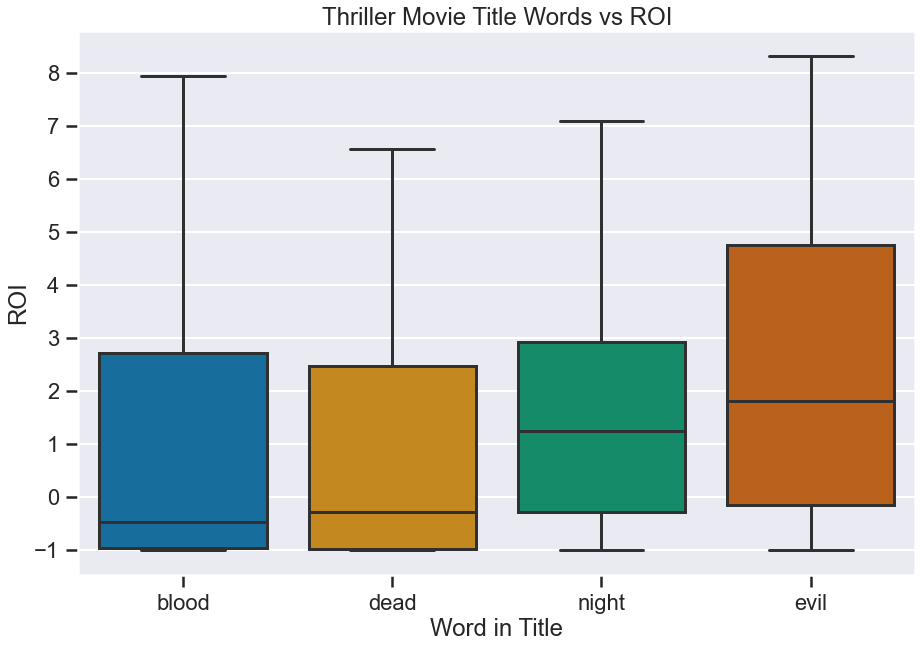

In [25]:
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.boxplot(x = thriller_boxplot_df['Word in Title'], y = thriller_boxplot_df['ROI'], showfliers = False)
ax.set_title("Thriller Movie Title Words vs ROI");
ax.set_yticks(np.arange(-1,9));

In [26]:
alien_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('alien')]
print('Median ROI for movies with "alien" in the title:',alien_roi['ROI'].median())

extra_mars = title_vs_gross.loc[title_vs_gross['movie'].str.contains('martian')]
mars_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('mars')]
mars_roi = mars_roi.drop([801,1875,3406,4162,5144])
mars_roi= mars_roi.append(extra_mars)
print('Median ROI for movies with "mars" in the title:',mars_roi['ROI'].median())

Median ROI for movies with "alien" in the title: 1.4589819278350515
Median ROI for movies with "mars" in the title: -0.5846114166666667


In [27]:
scifi_boxplot_df = pd.concat([alien_roi,mars_roi])

scifi_boxplot_df.loc[scifi_boxplot_df['movie'].str.contains('mar'),['Word in Title']] = 'mars'
scifi_boxplot_df.loc[scifi_boxplot_df['movie'].str.contains('alien'),['Word in Title']] = 'alien'

#scifi_boxplot_df

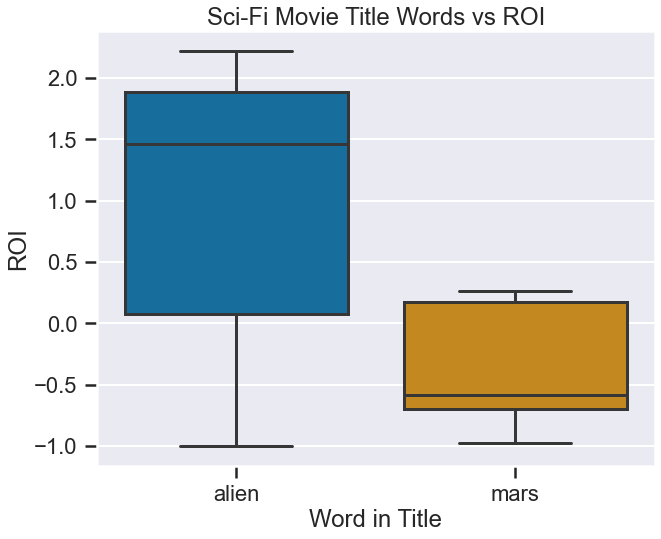

In [28]:
fig, ax = plt.subplots(figsize = (10,8))

ax = sns.boxplot(x = scifi_boxplot_df['Word in Title'], y =scifi_boxplot_df['ROI'], showfliers = False)
ax.set_title("Sci-Fi Movie Title Words vs ROI");

## Romance movie analysis (Not included in presentation)**



In [29]:
wedding_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('wedding')]
print('Median ROI for movies with "wedding" in the title:',wedding_roi['ROI'].median())
love_roi = title_vs_gross.loc[title_vs_gross['movie'].str.contains('love')]
print('Median ROI for movies with "love" in the title:',love_roi['ROI'].median())

Median ROI for movies with "wedding" in the title: 2.434441657608696
Median ROI for movies with "love" in the title: 0.12843673846153847


In [30]:
romance_boxplot_df = pd.concat([wedding_roi,love_roi])

romance_boxplot_df['Word in Title'] = romance_boxplot_df['movie'].str.contains('wedding')
romance_boxplot_df.loc[romance_boxplot_df['Word in Title'] == True, ['Word in Title']] = 'Wedding'
romance_boxplot_df.loc[romance_boxplot_df['Word in Title'] == False, ['Word in Title']] = 'Love'

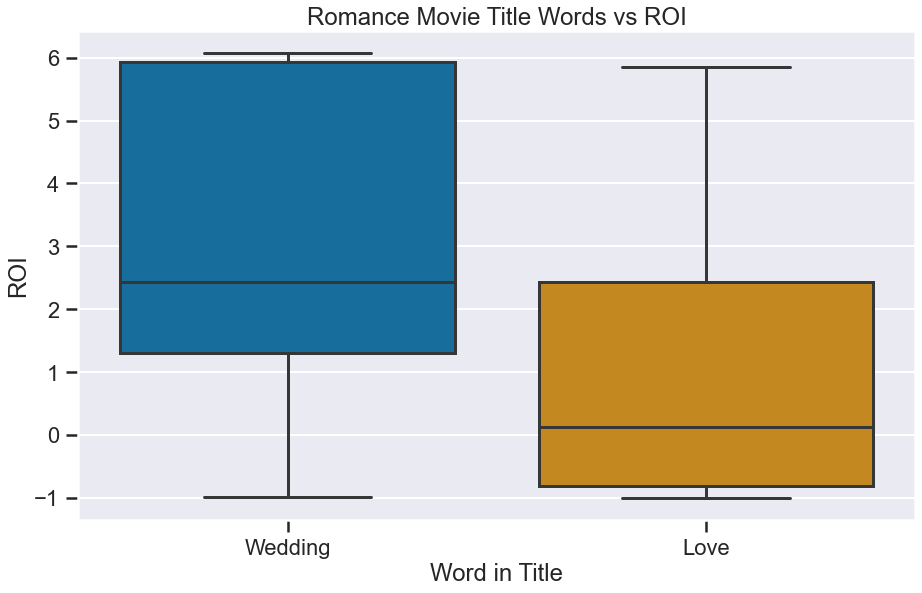

In [31]:
fig, ax = plt.subplots(figsize = (15,9))

ax = sns.boxplot(x = romance_boxplot_df['Word in Title'], y = romance_boxplot_df['ROI'], showfliers = False)
ax.set_title("Romance Movie Title Words vs ROI");

### Data Driven Solution 3: Director Choice

Finally, we created a dataframe containing film directors. We chose to use directors as they are involved with the films from start to finish (pre and post production). Directors also have a say in actors that are cast. 

In [32]:
directors_atleast3_list = list(sql_budgets_merged['primary_name'].value_counts().head(122).index)
remove_list = ['David Ayer', 'Joe Johnston', 'Mike Flanagan', 'Dan Gilroy', 'Frank Coraci']

directors_atleast3_list_cleaned = [i for i in directors_atleast3_list if i not in remove_list]

In [33]:
directors_atleast3_df = sql_budgets_merged.loc[sql_budgets_merged['primary_name'].isin(directors_atleast3_list_cleaned)]
directors_atleast3_df

,movie_id,primary_title,start_year,runtime_minutes,genres,primary_name,category,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit,ROI,profit_margin
4,tt0383010,the three stooges,2012,92.0,"Comedy,Family",Bobby Farrelly,director,5.1,28570,4,2012-04-13,the three stooges,30000000.0,44338224.0,54052249.0,2012.0,24052249.0,0.801742,44.498147
11,tt0433035,real steel,2011,127.0,"Action,Drama,Family",Shawn Levy,director,7.1,283534,31,2011-10-07,real steel,110000000.0,85463309.0,263880341.0,2011.0,153880341.0,1.398912,58.314439
14,tt0437086,alita battle angel,2019,122.0,"Action,Adventure,Sci-Fi",Robert Rodriguez,director,7.5,88207,24,2019-02-14,alita battle angel,170000000.0,85710210.0,402976036.0,2019.0,232976036.0,1.370447,57.813869
15,tt0443272,lincoln,2012,150.0,"Biography,Drama,History",Steven Spielberg,director,7.4,228701,73,2012-11-09,lincoln,65000000.0,182207973.0,273346281.0,2012.0,208346281.0,3.205327,76.220639
17,tt0446029,scott pilgrim vs the world,2010,112.0,"Action,Comedy,Fantasy",Edgar Wright,director,7.5,339338,22,2010-08-13,scott pilgrim vs the world,85000000.0,31611316.0,48056764.0,2010.0,-36943236.0,-0.434626,-76.874165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,tt7137846,breaking in,2018,88.0,"Action,Crime,Drama",James McTeigue,director,5.4,10154,19,2018-05-11,breaking in,6000000.0,46840590.0,51411620.0,2018.0,45411620.0,7.568603,88.329487
1452,tt7153766,unsane,2018,98.0,"Drama,Horror,Mystery",Steven Soderbergh,director,6.4,32049,70,2018-03-23,unsane,1500000.0,7690044.0,14244931.0,2018.0,12744931.0,8.496621,89.469938
1457,tt7401588,instant family,2018,118.0,"Comedy,Drama",Sean Anders,director,7.4,46728,20,2018-11-16,instant family,48000000.0,67363237.0,119736188.0,2018.0,71736188.0,1.494504,59.911869
1465,tt7958736,ma,2019,99.0,"Horror,Thriller",Tate Taylor,director,6.0,5322,66,2019-05-31,ma,5000000.0,36049540.0,44300625.0,2019.0,39300625.0,7.860125,88.713478


### Sort by Genre

We sorted our directors by genre; specifically targetting Thriller and Sci-Fi (we decided not to recommend Romance), then we  calculated median ROI's for each genre

In [44]:
romance_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Romance')]
thriller_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Thriller') ]
scifi_directors = directors_atleast3_df.loc[directors_atleast3_df['genres'].str.contains('Sci')]

In [45]:
rom_keep = list(romance_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])
thri_keep = list(thriller_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])
sci_keep = list(scifi_directors['primary_name'].value_counts().loc[lambda x: x>=2].reset_index()['index'])

rom_dir = romance_directors.loc[romance_directors['primary_name'].isin(rom_keep)]
thri_dir = thriller_directors.loc[thriller_directors['primary_name'].isin(thri_keep)]
sci_dir = scifi_directors.loc[scifi_directors['primary_name'].isin(sci_keep)]

#sci_dir['primary_name'].value_counts()

In [46]:
thriller_director_rois = thri_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
#thriller_director_rois

In [47]:
scifi_director_rois = sci_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
# scifi_director_rois

In [48]:
romance_director_rois = rom_dir.groupby(['primary_name'])[['ROI']].agg('median').sort_values(by = 'ROI', ascending = False)
romance_director_rois

,ROI
primary_name,
Jake Kasdan,6.245579
Will Gluck,5.856772
Jon M. Chu,5.733147
Tim Story,5.182822
David O. Russell,4.631472
Lasse Hallström,3.520151
Woody Allen,2.849973
Jonathan Levine,2.837387
David Frankel,2.402937


### Visualize Thriller Directors

We plotted a bar chart of the top 5 Thriller Directors by median ROI

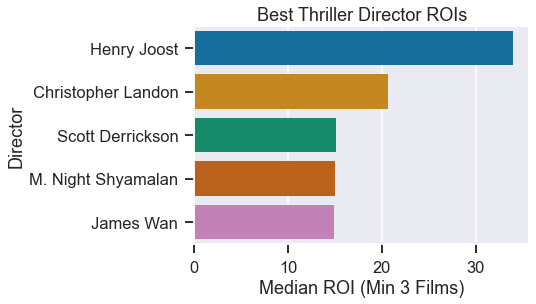

In [49]:
fig,ax = plt.subplots()

sns.set_context("talk")
ax = sns.barplot( y = thriller_director_rois.index[:5], x = thriller_director_rois.ROI[:5], data = thriller_director_rois);

ax.set_title('Best Thriller Director ROIs')
ax.set_ylabel('Director')
ax.set_xlabel('Median ROI (Min 3 Films)');

### Visualize Sci-Fi Directors

We plotted a bar chart of the top 5 Sci-Fi Directors by median ROI

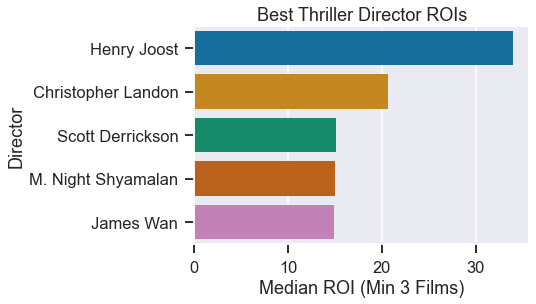

In [50]:
fig,ax = plt.subplots()

ax = sns.barplot( y = thriller_director_rois.index[:5], x = thriller_director_rois.ROI[:5], data = thriller_director_rois)

ax.set_title('Best Thriller Director ROIs')
ax.set_ylabel('Director')
ax.set_xlabel('Median ROI (Min 3 Films)');

### Visualize Romance Directors (Not included in presentation)

Bar chart of top 5 Directors vs ROI

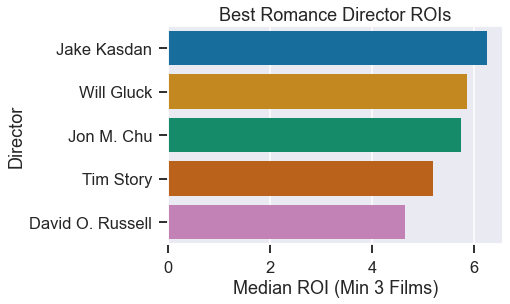

In [51]:
fig,ax = plt.subplots()

ax = sns.barplot( y = romance_director_rois.index[:5], x = romance_director_rois.ROI[:5], data = romance_director_rois)
ax.set_title('Best Romance Director ROIs')
ax.set_ylabel('Director')
ax.set_xlabel('Median ROI (Min 3 Films)');

# Final Recommendations:

1) We found that the most opportune genres to invest in were Sci-Fi and Thriller as they presented least amount of competition from top studios as well as high profit margins. 
    1a) For Sci-Fi movies, we found that the films with the word 'Alien'in the title had high ROI's
    1b) For Thriller movies, we found that films with the words 'Night' or 'Evil' in the title also had high ROI's

2) The ideal threshold for Production Budget was $90 million yielding maximal profit margins

3) For creative talent, we found the directors Francis Lawrence (for Sci-Fi) and Henry Joost (for Thrillers) had been shown to consistently direct films with high returns on investment 

### Although we included calculations for the Romance genre, in the end we decided to narrow our recommendations to only 2 genres. 